# <font size = 5>Setting up</font>

In [21]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import pandas as pd
from qutip import *
import scipy.constants
import pickle
from tkinter import filedialog # for prompting user to set analysis folder
import glob
# import lyse
import h5py
from pathlib import PureWindowsPath, PurePosixPath
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from sympy.physics.wigner import wigner_3j, wigner_6j
from lmfit import Model, Parameters
import pathlib

In [390]:
# fancy plot
import matplotlib.pyplot as plt
import numpy as np
def fancy_plot(x, y, fmt='', ax = None, plot_most_recent_pair = True, **kwargs):
    """Wraps around matplotlib.pyplot (aliased to plt) with last-point highlighting and statistics
    Plots x and y as in plt.plot, but a) averages together y-values with the same x-value and calculates and plots
    an error bar, and b) plots the final (x,y) point in a different color than the previous ones.
    Args:
        x: The x-data to be plotted. Assumed to be an iterable with contents of
            numeric type, including possibly np.nan
        y: The y-data to be plotted. Same assumptions on type.
        fmt: The format string. In contrast to ax.plot, it is a kwarg.
        ax: The axes object on which to plot. If None, plt.gca() is called.
        kwargs: Any kwarg that can be passed to ax.errorbar.
    Returns:
        ErrorbarContainer, as detailed in the docs for plt.errorbar
    Raises:
        ValueError if x and y are not of the same length
    """
    if(ax == None):
        ax = plt.gca()
    if(len(x) != len(y)):
        raise ValueError(
            "The input x and y arrays must be of the same length.")
    # Filter out the NaNs in either x or y while preserving order
    zipped_list = list(zip(x, y))
    nan_filter = filter(lambda v: (
        (not np.isnan(v[0])) and (not np.isnan(v[1]))), zipped_list)
    nan_stripped_list = list(nan_filter)
    # Pull off the last point so that it can be plotted in a different color
    if(len(nan_stripped_list) != 0):
        most_recent_xy_pair = nan_stripped_list[-1]
        nan_stripped_list = nan_stripped_list[:len(nan_stripped_list) - 1]
    else:
        most_recent_xy_pair = None
    # Sort the NaN-stripped list to make getting statistics faster for large data
    sorted_list = sorted(nan_stripped_list, key=(lambda v: v[0]))
    # Reconstitute to x- and y- lists
    if(len(sorted_list) > 0):
        x_sorted, y_sorted = zip(*sorted_list)
        sorted_x_list = list(x_sorted)
        sorted_y_list = list(y_sorted)
    else:
        sorted_x_list = []
        sorted_y_list = []
    # Perform statistics and condense repeated measurements
    index = 0
    final_x_list = []
    final_y_list = []
    final_error_list = []
    while(index < len(sorted_x_list)):
        current_x_value = sorted_x_list[index]
        final_x_list.append(current_x_value)
        y_list_for_current_x = []
        while(index < len(sorted_x_list) and sorted_x_list[index] == current_x_value):
            y_list_for_current_x.append(sorted_y_list[index])
            index += 1
        y_array_for_current_x = np.array(y_list_for_current_x)
        y_mean = sum(y_array_for_current_x) / float(len(y_array_for_current_x))
        final_y_list.append(y_mean)
        # Calculate the standard error of mean if possible
        if(len(y_list_for_current_x) == 1):
            final_error_list.append(np.nan)
        else:
            variance_estimate = sum(np.square(
                y_mean - y_array_for_current_x)) / float(len(y_array_for_current_x) - 1)
            standard_error_of_mean = np.sqrt(
                variance_estimate / len(y_array_for_current_x))
            final_error_list.append(standard_error_of_mean)
    # Convert all lists to np arrays
    final_x_values = np.array(final_x_list)
    final_y_values = np.array(final_y_list)
    final_error_values = np.array(final_error_list)
    # Plot the most recent point with a hardcoded but distinctive black diamond symbol
    
    if(most_recent_xy_pair != None) and plot_most_recent_pair:
        ax.plot(most_recent_xy_pair[0], most_recent_xy_pair[1], 'dr')
    # Plot and return the errorbar graph with the input kwargs
    return ax.errorbar(final_x_values, final_y_values, final_error_values, fmt=fmt, **kwargs)

In [3]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [4]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
c = 299792458 # m/s
h_planck = hbar*2*np.pi  # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
muB_cm1_G = muB / (100*c*h_planck*1e4) # Bohr magneton in units of cm-1 per Gauss
a0 = 5.2917720859e-11    # Bohr radius
muN = scipy.constants.physical_constants['nuclear magneton'][0]
eps0 = scipy.constants.epsilon_0
gS = 2.0023193043622
DebyeSI = 3.33564e-30
kB = 1.380649e-23

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

# <font size = 5>Zeeman Effect Calculator</font>

In [199]:
# calculate via Breit-Rabi (no plotting, labeling, etc.) 
def breitRabi_k40(b_field, m1, m2):
    """
    Code written by AYC. 
    Returns the transition frequency between mF states of K ground state manifold in Hz.
    TODO: rewrite this function to use imported constants, and use a numerical solver?
    Args:
    - b_field: specified in G
    """
    Inuc = 4
    ahf = -285.7308e6
    gI = .00017649
    gJ = 2.00229421
    muB = 927.4009994e-26
    planckConst = 6.6261e-34
    def x(b_field): return (gJ - gI) * muB * b_field / \
        10000 / ((Inuc + 1/2)*ahf*planckConst)
    def Energy(b_field, m): return -ahf*planckConst/4 + gI*muB*m*b_field/10000 + ahf * \
        planckConst*(Inuc + 1/2)/2*np.sqrt(1 + 4*m *
                                        x(b_field)/(2*Inuc + 1) + x(b_field)**2)
    def RFFreq(b_field, m1, m2): return (
        Energy(b_field, m1)-Energy(b_field, m2))/planckConst
    return RFFreq(b_field, m1, m2)

In [5]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mjj == mj - 1) and (mii == mi + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mjj == mj + 1 and mii == mi - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mjj == mj - 2 and mii == mi + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mjj == mj + 2 and mii == mi - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [6]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = None,
                                search_mode = False, splitting = 0, splitting_between_states = None, labeling_mode='lf'):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))
   
    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
            mF = mj + mi
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eigh(H) 
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting, labeling states, and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 0.5, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        # labeling states depending on high or low field:
        gL = 1 - me/mn           # gyro magnetic factor of the orbital
        gS = 2.0023193043622     # electron spin g-factor
        gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
        if labeling_mode=='lf':
            # print out (F,mF) basis
            basisF = []
            possible_Fs = np.arange(abs(I-J), abs(I+J)+1, 1)
            if gI > 0:
                possible_Fs = np.flip(possible_Fs)
            for F in possible_Fs:
                gF = gJ*(F*(F+1) - I*(I+1) + J*(J+1))/(2*F*(F+1)) # without dividing a positive
                if gF > 0:
                    # if positive, then mF negative to positive:
                    mF = np.linspace(-F, F, int(2*F+1))
                    for mf in mF:
                        basisF.append([F,mf])
                else:
                    # if negative, then mF positive to negative:
                    mF = np.flip(np.linspace(-F, F, int(2*F+1)))
                    for mf in mF:
                        basisF.append([F,mf])
            basisF = np.array(basisF)
            print('(F, mF) basis, low to high in energy: ')
            print(basisF)
        elif labeling_mode=='hf':
            # rank the mj mi basis based on the value of gJ * mJ + gI*mI:
            vals = []
            for b in basis:
                B_hf = 10*Ahf*hbar*2*np.pi/(muB *1e-4)
                vals.append(  Ahf*b[0]*b[1] + (gJ*b[0] + gI*b[1])*B_hf*1e-4*muB/(hbar*2*np.pi)    )
            sort_vals = np.argsort(np.array(vals))
            sorted_mJmI_basis = np.array(basis)
            sorted_mJmI_basis = sorted_mJmI_basis[sort_vals]
            print('(mJ, mI) basis, low to high in energy: ')
            print(sorted_mJmI_basis)
        elif labeling_mode == 'none':
            print('No state labeling')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        print('Frequencies (MHz)')
        print(freqs)
        print('')
        print('Frequency spacings (MHz), from low to high in state energy, at ' + str(B_main) +  ' G:')
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensitivity of shift (MHz per G), from low to high in state energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        if print_field_sensitivity_between is not None:
            lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
            higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
            differential_shift =  higher_state - lower_state
            # take derivative:
            dfdB = np.diff(differential_shift)/np.diff(B_fields)
            print( 'Field sensitivity of splitting, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
            print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        if splitting_between_states is not None:
            state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
            state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
            AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
            AB_freq_diff_min_index = np.argmin(AB_freq_differences)

            print(' ')
            print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
            splitting_error = state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting
            print('Splitting Error (MHz): ' + "{:.5f}".format(splitting_error ))
            if np.abs(splitting_error/splitting) >= 0.1: # if error is too big
                print('Note: large error might be due to bad guesses!')
    return 

(F, mF) basis, low to high in energy: 
[[ 1.  1.]
 [ 1.  0.]
 [ 1. -1.]
 [ 2. -2.]
 [ 2. -1.]
 [ 2.  0.]
 [ 2.  1.]
 [ 2.  2.]]


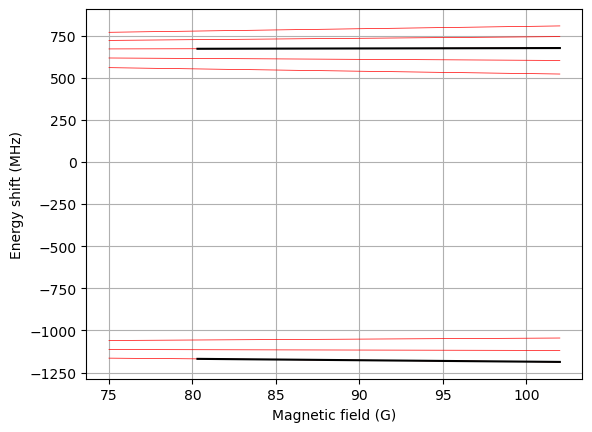

Frequencies (MHz)
[-1168.66983024 -1114.38988561 -1056.60154391   551.97502736
   613.87587226   671.48335341   725.58243749   776.74456925]

Frequency spacings (MHz), from low to high in state energy, at 80.3 G:
54.2799
57.7883
1608.5766
61.9008
57.6075
54.0991
51.1621
 
Field sensitivity of shift (MHz per G), from low to high in state energy, at 80.3 G:
-0.823
-0.177
0.556
-1.400
-0.553
0.177
0.821
1.400
 
Field sensitivity of splitting, df61 by dB:
1.0000 MHz per G
 
Closest B field (G): 75.00
Splitting Error (MHz): 1810.34304
Note: large error might be due to bad guesses!


In [7]:
# Zeeman calculator cell
B_start, B_end, num_B = 75, 102, 2000
B_main = 80.3
find_B_at_resonance_MHz = 24.5599

# Careful what you type in here!
Ahf, Bhf = Na23Ahf_s12, Na23Bhf_s12
L = 0
S = 1/2
J = 1/2
I, gI = Na23I, Na23gI

from_to = [1,6]

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = from_to, plot_range = None, 
                            single_B_field_calc_mode = True, print_field_sensitivity_between = from_to,
                            search_mode = True, splitting = find_B_at_resonance_MHz, splitting_between_states = from_to,
                            labeling_mode='lf')

# <font size = 5>NaK Feshbach resonance landscape & binding energy</font>

In [8]:
# generate FB resonance landscape for Na-Km72 and Na-Km92
def FB_resonance_landscape_Km92_Km72(B_interest):

    B = np.linspace(60,140,100000)
    # B = np.linspace(93,120,100000)
    # mean scattering length
    a_mean = 51

    # m72 FB resonances from Tiemann theory + updates
    m72_Bres_1 = 81.65 
    m72_Bres_2 = 90.40 
    m72_Bres_3 = 112.1964

    m72_B_zero_crossing_1 = m72_Bres_1 - 0.30
    m72_B_zero_crossing_2 = m72_Bres_2 - 6.50
    m72_B_zero_crossing_3 = m72_Bres_3 - 17.3923

    m72_B_resonances = np.array([m72_Bres_1, m72_Bres_2, m72_Bres_3])
    m72_B_zero_crossings = np.array([m72_B_zero_crossing_1, m72_B_zero_crossing_2, m72_B_zero_crossing_3])
    m72_B_width  = m72_B_resonances - m72_B_zero_crossings

    m72_a_bg = -710 

    # m92 FB resonances from Tiemann theory + updates  
    m92_Bres_1 = 78.35
    m92_Bres_2 = 89.80

    m92_B_zero_crossing_1 = m92_Bres_1 - 5.80
    m92_B_zero_crossing_2 = m92_Bres_2 - 9.55

    m92_B_resonances = np.array([m92_Bres_1, m92_Bres_2])
    m92_B_zero_crossings = np.array([m92_B_zero_crossing_1, m92_B_zero_crossing_2])
    m92_B_width  = m92_B_resonances - m92_B_zero_crossings

    m92_a_bg = -730 

    # calculate m72 scattering lengths:
    a_m72 = m72_a_bg
    for i in range(len(m72_B_resonances)):
        a_m72 *= (1 + m72_B_width[i] / (B - m72_B_resonances[i]) )

    # calculate m92 scattering lengths:
    a_m92 = m92_a_bg
    for i in range(len(m92_B_resonances)):
        a_m92 *= (1 + m92_B_width[i] / (B - m92_B_resonances[i]) )

    # generate data for B_interest:
    a_m72_interest = m72_a_bg
    a_m92_interest = m92_a_bg
    NaKm72_bound_state = False
    NaKm92_bound_state = False
    plot_B_interest = False
    Eb_NaKm72 = np.nan
    Eb_NaKm92 = np.nan

    if min(B) < B_interest < max(B):
        plot_B_interest = True
        for i in range(len(m72_B_resonances)):
            a_m72_interest *= (1 + m72_B_width[i] / (B_interest - m72_B_resonances[i]) )
        for i in range(len(m92_B_resonances)):
            a_m92_interest *= (1 + m92_B_width[i] / (B_interest - m92_B_resonances[i]) )
        
        NaKm72_bound_state = a_m72_interest > 0
        NaKm92_bound_state = a_m92_interest > 0

        if NaKm72_bound_state: # in kHz
            Eb_NaKm72 = 1e-3 * (hbar**2 / (2*muNa40K*u*(a_m72_interest*a0 - a_mean*a0)**2))/(hbar*2*np.pi)
            
        if NaKm92_bound_state: # in kHz
            Eb_NaKm92 = 1e-3 * (hbar**2 / (2*muNa40K*u*(a_m92_interest*a0 - a_mean*a0)**2))/(hbar*2*np.pi)

        # print stuff
        print('------------- RESULTS -------------------')
        print(f'Magnetic field of interest: {B_interest} G')
        print(f'Na-Km72 scattering length:  {a_m72_interest:.2f} a0')
        print(f'Na-Km92 scattering length:  {a_m92_interest:.2f} a0')
        print(f'Na-Km72 binding energy:     {Eb_NaKm72:.2f} (kHz)')
        print(f'Na-Km92 binding energy:     {Eb_NaKm92:.2f} (kHz)')
        print('--------------- END ---------------------')
    else:
        print('Magnetic field of interest OUT OF RANGE!')
    
    # plot:
    fig, ax = plt.subplots(figsize = (5.0,4.0))
    #if plot_B_interest:
    #    ax.axvline(x=B_interest, linestyle = '--', color = 'green')
    ax.plot(B,a_m72, color = 'blue', label=r'K $m_F$ = -7/2')
    ax.plot(B,a_m92, color = 'blue', linestyle = '--', label = r'K $m_F$ = -9/2')
    ax.legend()
    ax.set_ylim([-4000,4000])
    ax.grid()
    ax.set_title('Na-K scattering lengths', fontsize = 15) #  for Na and K $m_F = -7/2$ and $m_F = -9/2$')
    ax.set_xlabel('Magnetic field (G)', fontsize = 15)
    ax.set_ylabel('Scattering length ($a_0$)', fontsize = 15)
    ax.set_xlim([98,122])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return 

------------- RESULTS -------------------
Magnetic field of interest: 101.0 G
Na-Km72 scattering length:  643.66 a0
Na-Km92 scattering length:  -1698.78 a0
Na-Km72 binding energy:     352.06 (kHz)
Na-Km92 binding energy:     nan (kHz)
--------------- END ---------------------


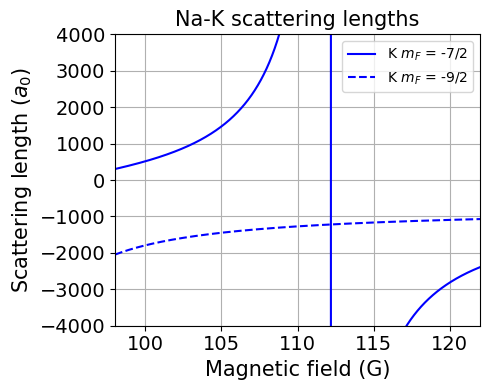

In [9]:
FB_resonance_landscape_Km92_Km72(B_interest = 101.0)

# <font size = 5>RF Heating analysis</font>

## <font size = 3>Miscelllaneous functions</font>

In [412]:
def get_average_trace(x, y):
    """Calculate unique x values and average corresponding y values after dropping NaNs."""
    # Combine x and y into a single array for easier handling
    combined_data = np.column_stack((x, y))
    # Remove rows with NaN values
    combined_data = combined_data[~np.isnan(combined_data).any(axis=1)]
    # Separate x and y after removing NaNs
    x_without_nan = combined_data[:, 0]
    y_without_nan = combined_data[:, 1:]
    unique_x = np.unique(x_without_nan)
    averaged_y = [np.mean(y_without_nan[x_without_nan == val, :]) for val in unique_x]
    return unique_x, averaged_y

## <font size = 3>Loading functions</font>

In [200]:
data_directory = '/Users/huanbui/Desktop/cloud size check/*'
data_folders = sorted(glob.glob(data_directory))
master_df_list = []
for i in range(len(data_folders)):
    df_paths_list = []
    # generate list of dataframe paths for dataset[dataset_number]
    for file in os.listdir(data_folders[i]):
        if file.endswith('.pkl'):
            df_paths_list.append(os.path.join(data_folders[i], file))

    # concatenate all df's into one df:
    df_list = []
    for j in range(len(df_paths_list)):
        df_list.append(pd.read_pickle(df_paths_list[j]))
    # filter
    master_df_list.append(pd.concat(df_list))

In [327]:
# separate a mixture spectrum df into bound and free parts
def bound_free_mixture_spectrum_df(df) -> dict:
    """
    Separates a mixture spectrum df into the bound and free parts.
    Assumes that the data was taken such that the frequency sampling of the free part is greater than 3.5kHz.
    Args:
    - A dataframe containing "RF_FREQ" column.
    """
    def find_x_separator(xdata, frequency_increment_cutoff=3.5e3):
        unique_xvals = np.array(sorted(np.unique(xdata)))
        increment_diff = np.gradient(unique_xvals)
        # returns x_separator if spectrum contains loss + atomic features
        # some datasets only have the loss feature
        u = unique_xvals[increment_diff > frequency_increment_cutoff]
        if len(u) > 0:
            return min(u)
        else:
            return max(unique_xvals) + frequency_increment_cutoff
    xdata = df["RF_FREQ"]
    x_separator = find_x_separator(xdata)
    df_bound, df_free = df[xdata < x_separator], df[xdata > x_separator]
    return df_bound, df_free

## <font size = 3>Fitting functions</font>

In [657]:
# double Lorenztian
from lmfit.models import LorentzianModel
def double_lorentzian(x, amp1, cen1, wid1, amp2, cen2, wid2, offset):
    """Evaluate sum of two lorentzians and a constant offset at x."""
    lorentzian1 = LorentzianModel(prefix='l1_')
    lorentzian2 = LorentzianModel(prefix='l2_')
    return (lorentzian1.eval(x=x, l1_amplitude=amp1, l1_center=cen1, l1_sigma=wid1) +
            lorentzian2.eval(x=x, l2_amplitude=amp2, l2_center=cen2, l2_sigma=wid2) +
            offset)

def fit_double_lorentzian(x, y, plot_initial_guess=False, loss = False, **kwargs):
    """Fit x, y data with the sum of two lorentzians and a constant offset using lmfit.
    Parameters:
    - Fit parameter bounds are set through kwargs.
    """
    model = Model(double_lorentzian)
    x_avg, y_avg = get_average_trace(x, y)
    if loss:
        params = model.make_params(
            amp1=np.sqrt(2 * np.pi) * 8 * (min(y_avg) - max(y_avg)), cen1=x_avg[np.argmin(y_avg)], wid1=8.0,
            amp2=np.sqrt(2 * np.pi) * 8 * (min(y_avg) - max(y_avg)), cen2=x_avg[np.argmin(y_avg)] - 20.0, wid2=8.0,
            offset=max(y_avg))
    else:
        params = model.make_params(
            amp1=np.sqrt(2 * np.pi) * 8 * (max(y_avg) - min(y_avg)), cen1=x_avg[np.argmax(y_avg)], wid1=8.0,
            amp2=np.sqrt(2 * np.pi) * 8 * (max(y_avg) - min(y_avg)), cen2=x_avg[np.argmax(y_avg)] - 20.0, wid2=8.0,
            offset=min(y_avg))
    params["cen1"].max = np.max(x)
    params["cen1"].min = np.min(x)
    params["cen2"].max = np.max(x)
    params["cen2"].min = np.min(x)
    if loss:
        params['amp1'].max = kwargs.get('amp1_max', 0.0)
        params['amp2'].max = kwargs.get('amp2_max', 0.0)
    params['wid1'].max = kwargs.get('wid1_max', 20.0)
    params['wid2'].max = kwargs.get('wid2_max', 20.0)
    # # minimum width set by frequency spacing in data, unless otherwise specified
    x_spacing = np.gradient(np.sort(np.unique(x))).min()
    params['wid1'].min = kwargs.get('wid1_min', x_spacing)
    params['wid2'].min = kwargs.get('wid2_min', x_spacing)
    if plot_initial_guess:
        model = Model(double_lorentzian)
        x_eval = np.linspace(min(x), max(x), 1000)
        components = model.eval(params=params, x=x_eval)
        plt.plot(x_eval, components, '-', color='red')
    # Perform the fit
    result = model.fit(y, params, x=x)
    # Return the fitting parameters and the fitted data
    return result

def plot_double_lorentzian_fit(x, params, **kwargs):
    """Plot the fit results."""
    model = Model(double_lorentzian)
    x = np.linspace(min(x), max(x), 1000)
    components = model.eval(params=params, x=x)
    plt.plot(x, components, '-', **kwargs)

## <font size = 3>Generate waterfall plots for X- and Y-widths</font>

In [739]:
# plot X- and Y-widths plot configurations:
# cheatsheet {0: 102.5, 1: 104.0, 2: 105, 3:101.75, 4: 104.5, 5: 100.5, 6,7,8,9: 101, 10: 105, 11: 104.5, 12,13,14: 103}
waterfall_ids = [0,1,3,5,6]
ranked_red_cutoff = [-np.inf, -np.inf, -285, -np.inf, -np.inf]
K_plot_spacing_multiplier = 4 # 13 for X, 4 for Y
NaK_plot_offset = 0.5 # 5 for X, 0.5 for Y 
plot_which_width = 'Y'
FIGURE_SIZE = (6,10)

# rearrange waterfall_ids by B-field: 
Bfield_list = []
for i in range(len(waterfall_ids)):
    df = master_df_list[waterfall_ids[i]]
    Bfield_list.append(df["FB_FIELD_FINAL"].iloc[0])
    new_order = np.flip(np.argsort(Bfield_list))
waterfall_ids = np.array(waterfall_ids)[new_order]
plt.rcParams.update({'font.family': 'Helvetica', 'font.size':14})

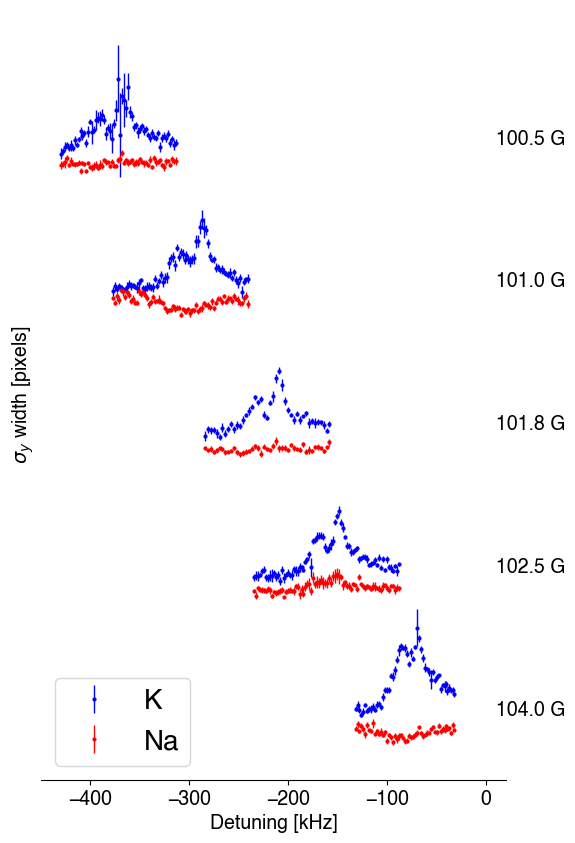

In [740]:
# plot X or Y-widths 
fig, ax = plt.subplots(figsize = FIGURE_SIZE)
for i in range(len(waterfall_ids)):
    df = master_df_list[waterfall_ids[i]]
    df = df[df['zcam_analysis']['K_good_shot'] == True]
    df_bound, df_free = bound_free_mixture_spectrum_df(df)

    # to avoid long tail in the red detuning, we cut anything below -275 kHz red detuned from atomic line
    detunings_khz = np.array(1e-3*(df_bound['RF_FREQ'] - breitRabi_k40(df_bound["FB_FIELD_FINAL"].iloc[0], m1 = -7/2, m2 = -9/2)))
    red_cutoff = detunings_khz > ranked_red_cutoff[i] 
    
    if waterfall_ids[i] not in [13, 14]:
        if plot_which_width == 'X':
            K_sigma_width = df_bound['zcam_analysis']['K_sigma_width_X_0'] 
            Na_sigma_width = df_bound['zcam_analysis']['Na_sigma_width_X_0'] 
        else:   
            K_sigma_width = df_bound['zcam_analysis']['K_sigma_width_Y_0'] 
            Na_sigma_width = df_bound['zcam_analysis']['Na_sigma_width_Y_0'] 
    else:
        if plot_which_width == 'X':
            K_sigma_width = df_bound['zcam_analysis']['K_sigma_width_X_1'] 
            Na_sigma_width = df_bound['zcam_analysis']['Na_sigma_width_X_1'] 
        else:
            K_sigma_width = df_bound['zcam_analysis']['K_sigma_width_Y_1'] 
            Na_sigma_width = df_bound['zcam_analysis']['Na_sigma_width_Y_1'] 
        
    # fit double lorentzian through K data:
    fit_result_K_sigma_width = fit_double_lorentzian(detunings_khz, K_sigma_width, plot_initial_guess=False)
    K_sigma_width_baseline = fit_result_K_sigma_width.params['offset'].value
    # fit double lorentzian through Na data:
    fit_result_Na_sigma_width_X = fit_double_lorentzian(detunings_khz, Na_sigma_width, plot_initial_guess=False)
    Na_sigma_width_baseline = fit_result_Na_sigma_width_X.params['offset'].value

    # plot X sigma width for K
    if i == 0:
        label_K = 'K'
        label_Na = 'Na'
    else:
        label_K = None
        label_Na = None
    fancy_plot(detunings_khz[red_cutoff], 
               K_sigma_width[red_cutoff] - K_sigma_width_baseline + i*K_plot_spacing_multiplier, 
               '.', color = 'blue', elinewidth = 1, markersize = 4,
               plot_most_recent_pair = False,
               label = label_K)

    # plot X sigma width for Na
    fancy_plot(detunings_khz[red_cutoff], 
               Na_sigma_width[red_cutoff] - Na_sigma_width_baseline + i*K_plot_spacing_multiplier - NaK_plot_offset, 
               '.', color = 'red', elinewidth = 1, markersize = 4,
               plot_most_recent_pair = False,
               label = label_Na)

    # annotate with B field (nominal)
    ax.annotate(f'{df_bound["FB_FIELD_FINAL"].iloc[0]:.1f} G', xy = (10, i*K_plot_spacing_multiplier ))

plt.legend(loc="lower left", fontsize = 20)
if plot_which_width == 'X':
    plt.ylabel(r'$\sigma_{x}$ width [pixels]')
else:
    plt.ylabel(r'$\sigma_{y}$ width [pixels]')
plt.xlabel('Detuning [kHz]')
plt.xlim([None, 20])
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False) 
for pos in ['right', 'top', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
plt.show()

## <font size = 3>Generate waterfall plots for X-widths vs counts</font>

In [736]:
# plot X-widths vs counts:
# cheatsheet {0: 102.5, 1: 104.0, 2: 105, 3:101.75, 4: 104.5, 5: 100.5, 6,7,8,9: 101, 10: 105, 11: 104.5, 12,13,14: 103}
waterfall_ids = [0,1,3,5,6]
ranked_red_cutoff = [-np.inf, -np.inf, -285, -np.inf, -np.inf]
plot_spacing_multiplier = 10 # 10 for K, 13 for Na
plot_which_species = 'K' # K
FIGURE_SIZE = (6,10)

# rearrange waterfall_ids by B-field: 
Bfield_list = []
for i in range(len(waterfall_ids)):
    df = master_df_list[waterfall_ids[i]]
    Bfield_list.append(df["FB_FIELD_FINAL"].iloc[0])
    new_order = np.flip(np.argsort(Bfield_list))
waterfall_ids = np.array(waterfall_ids)[new_order]
plt.rcParams.update({'font.family': 'Helvetica', 'font.size':14})

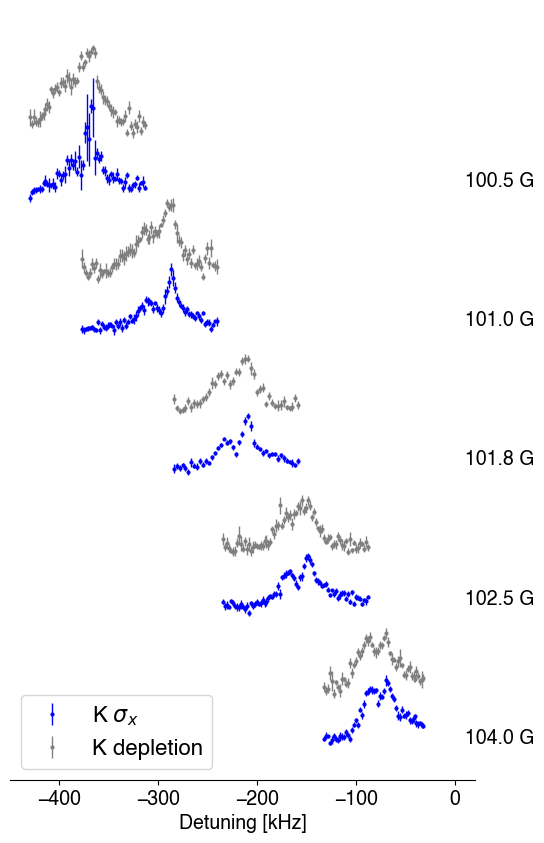

In [737]:
# plot X-widths vs counts
plt.rcParams.update({'font.family': 'Helvetica', 'font.size':14})
plot_counter = 0
fig, ax = plt.subplots(figsize = FIGURE_SIZE)

for i in range(len(waterfall_ids)):
    df = master_df_list[waterfall_ids[i]]
    df = df[df['zcam_analysis']['K_good_shot'] == True]
    df_bound, df_free = bound_free_mixture_spectrum_df(df)

    # to avoid long tail in the red detuning, we cut anything below -275 kHz red detuned from atomic line
    detunings_khz = np.array(1e-3*(df_bound['RF_FREQ'] - breitRabi_k40(df_bound["FB_FIELD_FINAL"].iloc[0], m1 = -7/2, m2 = -9/2)))
    red_cutoff = detunings_khz > ranked_red_cutoff[i] 
    
    if waterfall_ids[i] not in [13, 14]:
        if plot_which_species == 'K':
            sigma_width = df_bound['zcam_analysis']['K_sigma_width_X_0'] 
            counts = df_bound['zcam_analysis']['K_CountLarge_0']
        else:
            sigma_width = df_bound['zcam_analysis']['Na_sigma_width_X_0'] 
            counts = df_bound['zcam_analysis']['Na_CountLarge_0']
    else:
        if plot_which_species == 'K':
            sigma_width = df_bound['zcam_analysis']['K_sigma_width_X_1'] 
            counts = df_bound['zcam_analysis']['K_CountLarge_1']
        else:
            sigma_width = df_bound['zcam_analysis']['Na_sigma_width_X_1'] 
            counts = df_bound['zcam_analysis']['Na_CountLarge_1']
        
    # fit double lorentzian through K data:
    fit_result_sigma_width = fit_double_lorentzian(detunings_khz, sigma_width, plot_initial_guess=False)
    sigma_width_baseline = fit_result_sigma_width.params['offset'].value
    # fit double Lorenztian through K counts:
    fit_result_counts = fit_double_lorentzian(detunings_khz, counts, plot_initial_guess=False, loss=True)
    counts_baseline = fit_result_counts.params['offset'].value
    depletion = 1 - counts / counts_baseline
    
    # plot X sigma width for Na or K
    if i == 0:
        if plot_which_species == 'K':
            label_width = r'K $\sigma_x$'
            label_counts = 'K depletion'
            c = 'blue'
        else:
            label_width = r'Na $\sigma_x$'
            label_counts = 'Na depletion'
            c = 'red'
    else:
        label_width = None
        label_counts = None

    fancy_plot(detunings_khz[red_cutoff], 
               sigma_width[red_cutoff] - sigma_width_baseline + i*plot_spacing_multiplier, 
               '.', color = c, elinewidth = 1, markersize = 4,
               plot_most_recent_pair = False,
               label = label_width)
    
    fancy_plot(detunings_khz[red_cutoff], 
               sigma_width_baseline * depletion[red_cutoff]/4 + i*plot_spacing_multiplier +4.0, 
               '.', color = 'gray', elinewidth = 1, markersize = 4,
               plot_most_recent_pair = False,
               label = label_counts)

    # annotate with B field (nominal)
    ax.annotate(f'{df_bound["FB_FIELD_FINAL"].iloc[0]:.1f} G', xy = (10, i*plot_spacing_multiplier ))

plt.legend(loc="lower left", fontsize = 16)
# if plot_which_width == 'X':
#     plt.ylabel(r'$\sigma_{x}$ width [$\mu$m]')
# else:
#     plt.ylabel(r'$\sigma_{y}$ width [$\mu$m]')
plt.xlabel('Detuning [kHz]')
plt.xlim([None, 20])
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False) 
for pos in ['right', 'top', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
plt.show()

## <font size = 3>Saturation plots trimer vs dimer</font>

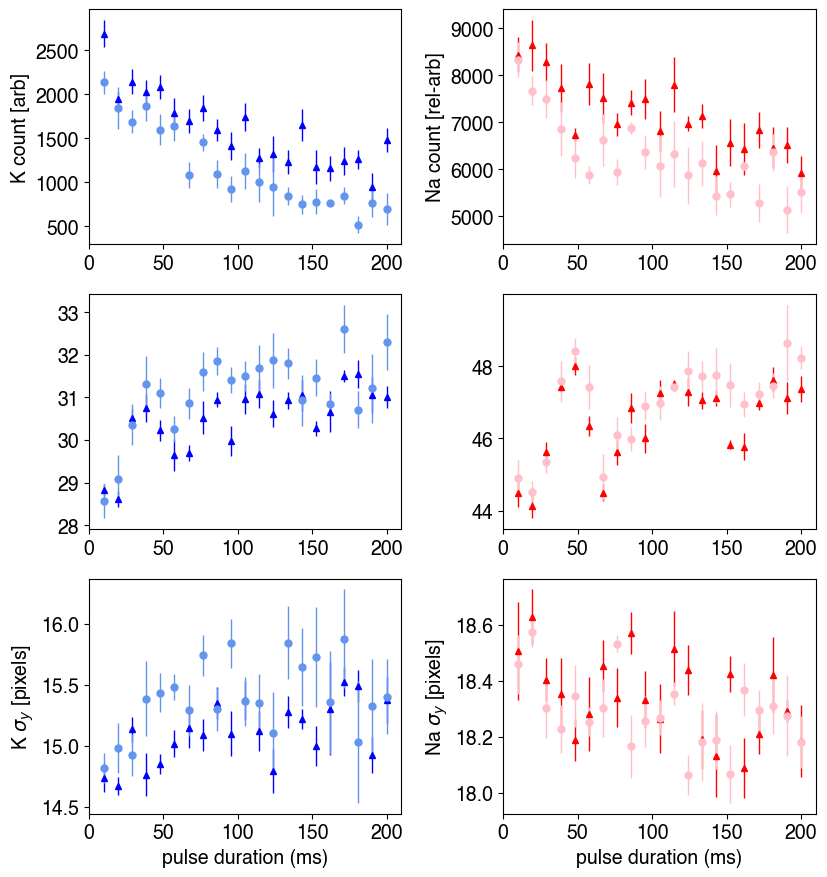

In [824]:
# dataset 15 is the one...
df_saturation = master_df_list[15]
df_saturation = df_saturation[df_saturation['zcam_analysis']['K_good_shot'] == True]
df_saturation = df_saturation[df_saturation['zcam_analysis']['K_sigma_width_X_0'] < 37]
trimer_freq = np.min(np.unique(df_saturation['RF_FREQ']))
dimer_freq = np.max(np.unique(df_saturation['RF_FREQ']))

trimer_df = df_saturation[df_saturation['RF_FREQ'] == trimer_freq] 
dimer_df  = df_saturation[df_saturation['RF_FREQ'] == dimer_freq]

# plotting 
fig, ax = plt.subplots(3,2, figsize = (8.5,9))
# K count depletion
fancy_plot(trimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           trimer_df['zcam_analysis']['K_CountLarge_0'], '^',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 5, ax=ax[0,0], color = 'blue')
fancy_plot(dimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           dimer_df['zcam_analysis']['K_CountLarge_0'], '.',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 10, ax=ax[0,0], color = 'cornflowerblue')
ax[0,0].set_ylabel('K count [arb]')
# K sigma width X saturation
fancy_plot(trimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           trimer_df['zcam_analysis']['K_sigma_width_X_0'], '^',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 5, ax=ax[1,0], color = 'blue')
fancy_plot(dimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           dimer_df['zcam_analysis']['K_sigma_width_X_0'], '.',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 10, ax=ax[1,0], color = 'cornflowerblue')
# K sigma width Y saturation
fancy_plot(trimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           trimer_df['zcam_analysis']['K_sigma_width_Y_0'], '^',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 5, ax=ax[2,0], color = 'blue')
fancy_plot(dimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           dimer_df['zcam_analysis']['K_sigma_width_Y_0'], '.',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 10, ax=ax[2,0], color = 'cornflowerblue')
ax[2,0].set_ylabel(r'K $\sigma_y$ [pixels]')
ax[2,0].set_xlabel('pulse duration (ms)')

# Na count depletion
fancy_plot(trimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           trimer_df['zcam_analysis']['Na_CountLarge_0'] * 1.61, '^',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 5, ax=ax[0,1], color = 'red')
fancy_plot(dimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           dimer_df['zcam_analysis']['Na_CountLarge_0'] * 1.61, '.',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 10, ax=ax[0,1], color = 'pink')
ax[0,1].set_ylabel('Na count [rel-arb]')
# Na sigma width X saturation
fancy_plot(trimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           trimer_df['zcam_analysis']['Na_sigma_width_X_0'], '^',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 5, ax=ax[1,1], color = 'red')
fancy_plot(dimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           dimer_df['zcam_analysis']['Na_sigma_width_X_0'], '.',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 10, ax=ax[1,1], color = 'pink')
# Na sigma width Y saturation
fancy_plot(trimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           trimer_df['zcam_analysis']['Na_sigma_width_Y_0'], '^',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 5, ax=ax[2,1], color = 'red')
fancy_plot(dimer_df['RF_BLACKMAN_PULSE_TIME']*1e3, 
           dimer_df['zcam_analysis']['Na_sigma_width_Y_0'], '.',
           plot_most_recent_pair=False, elinewidth = 1, markersize = 10, ax=ax[2,1], color = 'pink')
ax[2,1].set_ylabel(r'Na $\sigma_y$ [pixels]')
ax[2,1].set_xlabel('pulse duration (ms)')
for i in range(3):
    for j in range(2):
        ax[i,j].set_xlim([0,210])
        ax[i,j].set_xticks(np.arange(0, 210, 50))
plt.tight_layout()
plt.show()

## <font size = 3>Comparing contact tails: counts vs cloud size/temperature</font>

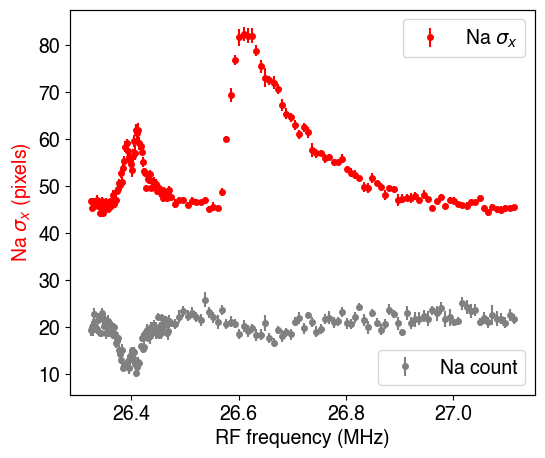

In [932]:
# good indices: 0, 1, 6
df_contact_tail = master_df_list[0]
df_contact_tail = df_contact_tail[df_contact_tail['zcam_analysis']['K_good_shot'] == True]

fig, ax = plt.subplots(figsize = (6,5))
fancy_plot(df_contact_tail['RF_FREQ']*1e-6, 
           df_contact_tail['zcam_analysis']['Na_CountLarge_0']/150, '.', 
           markersize=8, color = 'gray', 
           plot_most_recent_pair=False, label='Na count',
           ax = ax)
ax2 = ax.twiny()
ax2.set_ylabel('Na counts [arb]')
fancy_plot(df_contact_tail['RF_FREQ']*1e-6, 
           3*(df_contact_tail['zcam_analysis']['Na_sigma_width_X_0'] - 28.25), '.', 
           markersize=8, color = 'red', 
           plot_most_recent_pair=False, label = r'Na $\sigma_x$',
           ax = ax2)
# fancy_plot(df_contact_tail['RF_FREQ'], 
#            7.5*(df_contact_tail['zcam_analysis']['K_sigma_width_Y_0']-14.25), '.', 
#            markersize=8, color = 'cornflowerblue', 
#            plot_most_recent_pair=False)
ax.set_ylabel(r'Na $\sigma_x$ (pixels)', color = 'red')
ax.set_xlabel('RF frequency (MHz)')
ax2.set_xticks([])
ax.legend(loc = 'lower right')
ax2.legend(loc="upper right")
plt.show()